**DATA 608** Module 4   
Eunkyu Hahm

In [18]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

import plotly as py
import plotly.graph_objs as go

from pyproj import Proj, transform

import matplotlib.pyplot as plt

import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
from functools import partial

In [19]:
url = 'https://data.cityofnewyork.us/resource/uvpi-gqnh.json'
trees = pd.read_json(url)
trees.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,2015-09-05,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,2015-08-30,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [20]:
cat_type = CategoricalDtype(categories=["Poor", "Fair", "Good"], ordered = True)
trees['health'] = trees['health'].astype(cat_type)
print(trees['health'].describe())
print(trees['health'].cat.codes[:10])
trees['health'].isna().sum()
trees['health'] = trees['health'].fillna('Fair')
trees['health'] = trees['health'].cat.codes
print(trees['health'][:10])
print(trees['health'].describe())

count      973
unique       3
top       Good
freq       736
Name: health, dtype: object
0    1
1    1
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    1
dtype: int8
0    1
1    1
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    1
Name: health, dtype: int8
count    1000.000000
mean        1.682000
std         0.570264
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: health, dtype: float64


In [21]:
trees['steward'] = trees['steward'].fillna('None')

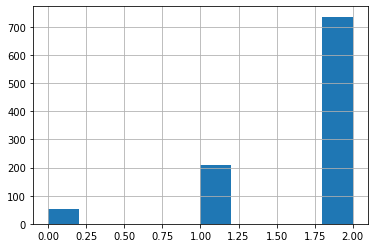

In [22]:
trees['health'].hist()
plt.show()

In [23]:
app = dash.Dash()

app.layout = html.Div(children=[
    html.H1(children = 'NYC Street Tree Health'),
    html.P('These graphics display the overall health of trees along city streets in NYC'),
    html.P('First select a Borough: '),
    dcc.RadioItems(
        id='dropdown-a',
        options=[{'label': i, 'value': i} for i in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']],
        value='Queens'
    ),
    html.Div(id='output-a'),
    html.P("0 = Poor Health; 1 = Fair Health, 2 = Good Health"),
    dcc.RadioItems(
        id='dropdown-b',
        options=[{'label': i, 'value': i} for i in trees['steward'].unique()],
        value='None'
    ),
    html.Div(id='output-b'),
    html.P("0 = Poor Health; 1 = Fair Health, 2 = Good Health")
    ])


In [24]:
@app.callback(
        Output(component_id='output-a', component_property='children'),
        [Input(component_id='dropdown-a', component_property='value')]
        )
def boro_graph(input_data):
    df = trees[trees.boroname == input_data]
    
    return dcc.Graph(
            id='Health by Borough',
            figure={
                    'data':[
              {'x':df['health'], 'type': 'histogram','name': 'Health by Borough'}
          ],
          'layout':{
              'title':"Health by Borough"
                  }
          }
              )

In [25]:
@app.callback(
        Output(component_id='output-b', component_property='children'),
        [Input(component_id='dropdown-b', component_property='value')]
        )

def steward_graph(input_data):
    df = trees[trees.steward == input_data]
    
    return dcc.Graph(
            id='Health by Steward',
            figure={
                    'data':[
              {'x':df['health'], 'type': 'histogram','name': 'Health by Stewardship'}
          ],
          'layout':{
              'title':"Health by Stewardship"
                  }
          }
              )


if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


OSError: [Errno 48] Address already in use